In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# ==========================================
# 0. CONFIGURAZIONE
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LR = 0.001
EPOCHS = 150
N_ITEMS = 5  
W_SEMANTIC = 0.4
WARMUP_EPOCHS = 0
RATIO = 0.01

In [3]:
# --- 1. DATASET MNIST SORTING ---
class MNISTSortingDataset(Dataset):
    def __init__(self, mnist_dataset, length=10000):
        self.length = length
        self.n_items = N_ITEMS
        
        # Pre-loading in RAM per velocità (Opzionale ma consigliato)
        print("Caricamento dati in RAM...")
        data = mnist_dataset.data.float() / 255.0
        self.data = (data - 0.1307) / 0.3081
        self.data = self.data.unsqueeze(1) # (N, 1, 28, 28)
        self.targets = mnist_dataset.targets
        print("Dati pronti.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Pesca casuale
        indices = torch.randperm(len(self.data))[:self.n_items]
        
        images = self.data[indices]
        labels = self.targets[indices]
        
        # Calcolo Permutazione Target
        sort_indices = torch.argsort(labels)
        ranks = torch.argsort(sort_indices)
        
        target_matrix = torch.zeros((self.n_items, self.n_items))
        for i in range(self.n_items):
            target_matrix[i, ranks[i]] = 1.0
            
        return images, target_matrix

In [4]:
class PrecomputedMNISTSortingDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, length=10000):
        self.images_tensor = images_tensor
        self.length = length
        
        print(f"Pre-computing {length} targets in RAM... (pazienta qualche secondo)")
        
        # 1. Pre-generiamo TUTTI gli indici casuali ora
        # Shape: (length, 5) -> contiene gli indici delle immagini da pescare
        self.indices = torch.randint(0, len(images_tensor), (length, N_ITEMS))
        
        # 2. Pre-calcoliamo TUTTE le matrici target ora
        self.targets = torch.zeros((length, N_ITEMS, N_ITEMS))
        
        # Usiamo i labels originali per calcolare le matrici
        # Questo loop gira solo una volta all'avvio!
        for i in range(length):
            # Recuperiamo le label dei 5 esempi scelti
            idxs = self.indices[i]
            batch_labels = labels_tensor[idxs]
            
            # Calcolo ordinamento
            sort_indices = torch.argsort(batch_labels)
            ranks = torch.argsort(sort_indices)
            
            # Costruzione matrice
            for r in range(N_ITEMS):
                self.targets[i, r, ranks[r]] = 1.0
        
        print("Pre-computation finita. Training sarà istantaneo.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Durante il training, facciamo ZERO calcoli.
        # Solo copia memoria -> memoria.
        img_indices = self.indices[idx]
        images = self.images_tensor[img_indices]
        target = self.targets[idx]
        
        return images, target

In [5]:
class SortingNet(nn.Module):
    def __init__(self):
        super(SortingNet, self).__init__()
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
            nn.Flatten()
        )
        self.feat_dim = 320 
        
        # MLP Reasoning
        self.mlp = nn.Sequential(
            nn.Linear(N_ITEMS * self.feat_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, N_ITEMS * N_ITEMS) 
        )
        
    def forward(self, x):
        # x shape: (Batch, 5, 1, 28, 28)
        batch_size = x.size(0)
        
        # --- OTTIMIZZAZIONE ---
        # "Schiacciamo" la dimensione 5 dentro il batch
        # Diventa: (Batch * 5, 1, 28, 28)
        # La CNN processerà 32*5 = 160 immagini in parallelo in un colpo solo!
        x_reshaped = x.view(batch_size * N_ITEMS, 1, 28, 28)
        
        features = self.cnn(x_reshaped) # Shape: (Batch * 5, 320)
        
        # Torniamo alla forma separata: (Batch, 5 * 320)
        features = features.view(batch_size, N_ITEMS * self.feat_dim)
        
        out = self.mlp(features)
        out = out.view(batch_size, N_ITEMS, N_ITEMS)
        return torch.sigmoid(out)

In [6]:
# ==========================================
# 2. LA SEMANTIC LOSS (Formula del Paper)
# ==========================================
def semantic_loss_exactly_one(probs, epsilon=1e-6):
    """
    Implementazione vettoriale della loss exactly-one.
    Formula: -log( sum( p_i * prod_{j!=i}(1-p_j) ) )
    """
    # Probabilità che l'evento NON accada
    q = 1.0 - probs
    
    # Prodotto di tutti i q nella riga (o colonna)
    row_prod = torch.prod(q + epsilon, dim=1, keepdim=True)
    
    # Calcolo del termine p_i * prod_{j!=i}(1-p_j)
    # Usiamo la divisione per rimuovere il termine (1-p_i) dal prodotto totale
    term = probs * (row_prod / (q + epsilon))
    
    # La probabilità che ESATTAMENTE UNO sia vero è la somma di questi termini
    prob_constraint = torch.sum(term, dim=1)
    
    # Loss = Logaritmo negativo della probabilità
    return torch.mean(-torch.log(prob_constraint + epsilon))

def compute_full_semantic_loss(matrix_probs):
    """Calcola la loss sia per le righe che per le colonne."""
    loss = 0
    # Vincolo sulle Righe (Ogni immagine va in una sola posizione)
    for i in range(N_ITEMS):
        loss += semantic_loss_exactly_one(matrix_probs[:, i, :])
    
    # Vincolo sulle Colonne (Ogni posizione ha una sola immagine)
    for j in range(N_ITEMS):
        loss += semantic_loss_exactly_one(matrix_probs[:, :, j])
        
    return loss

In [7]:
def train_semisupervised(model, train_loader, val_loader, use_semantic_loss=True, labeled_ratio=0.05, epochs=30, w_semantic=0.4):    
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_none = nn.BCELoss(reduction='none') 
    
    print(f"\n--- Training Semi-Sup | Labels: {labeled_ratio*100}% | Semantic Loss: {use_semantic_loss} | W_SEMANTIC: {w_semantic} ---")
    
    history = {'loss': [], 'validity': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        # Gestione Warm-up
        current_w = 0.0
        if use_semantic_loss and epoch >= WARMUP_EPOCHS:
            current_w = w_semantic
            
        desc = f"Epoch {epoch+1} (W={current_w})"
        progress_bar = tqdm(train_loader, desc=desc, ascii=True)
        
        for i, (imgs, targets) in enumerate(progress_bar):
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            
            # 1. MASCHERA SEMI-SUPERVISIONATA
            # Generiamo una maschera casuale: 1 se etichettato, 0 se no
            mask_labeled = (torch.rand(imgs.size(0)) < labeled_ratio).float().to(DEVICE)
            
            # 2. LOSS SUPERVISIONATA (Solo su mask=1)
            # 1. Calcolo Loss Supervisionata (Identico a prima, corretto)
            raw_sup = criterion_none(out, targets)
            mask_expanded = mask_labeled.view(-1, 1, 1)
            masked_sup_loss = raw_sup * mask_expanded
            
            num_labeled = mask_labeled.sum()
            if num_labeled > 0:
                sup_loss = masked_sup_loss.sum() / num_labeled
            else:
                sup_loss = torch.tensor(0.0).to(DEVICE)
            
            # 2. Calcolo Semantic Loss (MIGLIORAMENTO A: Formula del PDF)
            # Usiamo 'current_w' come Lambda (λ) tra 0 e 1
            sem_loss = torch.tensor(0.0).to(DEVICE)
            
            if current_w > 0:
                # Opzionale: Calcola Semantic Loss solo sui dati NON etichettati per efficienza
                # mask_unlabeled = 1.0 - mask_labeled
                # sem_loss_all = compute_full_semantic_loss_elementwise(out) # Richiede modifica alla funzione loss
                # sem_loss = (sem_loss_all * mask_unlabeled).sum() / (mask_unlabeled.sum() + 1e-6)
                
                # Per ora manteniamo la versione standard (su tutto il batch) come da paper originale
                sem_loss = compute_full_semantic_loss(out)

            # 3. COMBINAZIONE CONVESSA (Come richiesto dal PDF )
            # L = (1 - λ) * L_sup + λ * L_sem
            # Questo bilancia automaticamente le due forze.
            if num_labeled > 0:
                # Se abbiamo etichette, usiamo la formula bilanciata
                loss = ((1.0 - current_w) * sup_loss) + (current_w * sem_loss)
            else:
                # Se il batch è tutto non etichettato, usiamo solo la Semantic Loss
                # (Moltiplicare per current_w qui ridurrebbe troppo il gradiente, meglio lasciarla pura)
                loss = sem_loss 
            
            # Backprop
            if loss.requires_grad:
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            progress_bar.set_postfix(sup=f"{sup_loss:.3f}", sem=f"{sem_loss:.3f}")
            
        # --- VALUTAZIONE ---
        model.eval()
        valid_count = 0
        exact_match = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                
                preds = torch.argmax(out, dim=2)
                targs = torch.argmax(y, dim=2)
                
                # Check Validità (Constraint)
                for b in range(x.size(0)):
                    if len(torch.unique(preds[b])) == N_ITEMS:
                        valid_count += 1
                
                # Check Esattezza (Accuracy)
                matches = (preds == targs).all(dim=1)
                exact_match += matches.sum().item()
                total += x.size(0)
        
        val_validity = 100 * valid_count / total
        val_accuracy = 100 * exact_match / total
        
        history['loss'].append(total_loss / len(train_loader))
        history['validity'].append(val_validity)
        history['accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1} | Validity: {val_validity:.2f}% | Exact Match: {val_accuracy:.2f}%")
        
    return history

In [8]:
# --- SETUP DATI ---
# Carica MNIST standard
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# raw_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
# raw_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

# full_train_dataset = MNISTSortingDataset(raw_train, length=60000) 

# train_size = int(0.8 * len(full_train_dataset))
# val_size = len(full_train_dataset) - train_size

# train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

# Usa TUTTI i dati disponibili (60k) per il semi-supervised
# test_dataset = MNISTSortingDataset(raw_test, length=10000)

# train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [9]:
# --- A. Caricamento e Pre-processing in RAM (Una volta sola) ---
print("Caricamento dataset MNIST in RAM...")
# Scarichiamo i dati raw
raw_train = datasets.MNIST('./data', train=True, download=True)
raw_test = datasets.MNIST('./data', train=False, download=True)

# Convertiamo TUTTO in tensori float e normalizziamo SUBITO
# Training (60k)
X_all = raw_train.data.float() / 255.0
X_all = (X_all - 0.1307) / 0.3081
X_all = X_all.unsqueeze(1) # Shape: (60000, 1, 28, 28)
Y_all = raw_train.targets

# Test (10k)
X_test = raw_test.data.float() / 255.0
X_test = (X_test - 0.1307) / 0.3081
X_test = X_test.unsqueeze(1)
Y_test = raw_test.targets

# --- B. Split Manuale dei Tensori (80% Train / 20% Val) ---
# Non usiamo random_split sui dataset, ma splittiamo i tensori stessi
split_idx = int(0.8 * len(X_all)) # 48.000

# Slicing dei tensori (crea viste in memoria, molto efficiente)
X_train, X_val = X_all[:split_idx], X_all[split_idx:]
Y_train, Y_val = Y_all[:split_idx], Y_all[split_idx:]

print(f"Dati in RAM -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- C. Creazione Dataset Veloci ---
# Passiamo i tensori specifici a ogni dataset
# length=... definisce quante "triplette" generare per epoca. 
# Mettiamo valori alti per sfruttare i dati.
train_ds = PrecomputedMNISTSortingDataset(X_train, Y_train, length=48000)
val_ds = PrecomputedMNISTSortingDataset(X_val, Y_val, length=2000)
test_ds = PrecomputedMNISTSortingDataset(X_test, Y_test, length=10000)

# DataLoader (num_workers=0 è obbligatorio qui per evitare overhead inutile)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Setup completato. Ready to train!")

Caricamento dataset MNIST in RAM...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.29MB/s]


Dati in RAM -> Train: 48000, Val: 12000, Test: 10000
Pre-computing 48000 targets in RAM... (pazienta qualche secondo)
Pre-computation finita. Training sarà istantaneo.
Pre-computing 2000 targets in RAM... (pazienta qualche secondo)
Pre-computation finita. Training sarà istantaneo.
Pre-computing 10000 targets in RAM... (pazienta qualche secondo)
Pre-computation finita. Training sarà istantaneo.
Setup completato. Ready to train!



>>> TRAINING CON W_SEMANTIC = 0.1

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.1 ---


Epoch 1 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 11.80% | Exact Match: 0.75%


Epoch 2 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 13.15% | Exact Match: 1.35%


Epoch 3 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 13.15% | Exact Match: 2.15%


Epoch 4 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 16.35% | Exact Match: 3.05%


Epoch 5 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 19.85% | Exact Match: 3.55%


Epoch 6 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 17.40% | Exact Match: 3.75%


Epoch 7 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 20.25% | Exact Match: 4.00%


Epoch 8 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 22.85% | Exact Match: 5.15%


Epoch 9 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 23.40% | Exact Match: 6.00%


Epoch 10 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 21.05% | Exact Match: 5.90%


Epoch 11 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 21.45% | Exact Match: 5.90%


Epoch 12 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 24.80% | Exact Match: 5.90%


Epoch 13 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 22.50% | Exact Match: 5.65%


Epoch 14 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 24.60% | Exact Match: 7.00%


Epoch 15 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 27.60% | Exact Match: 8.75%


Epoch 16 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 25.15% | Exact Match: 7.60%


Epoch 17 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 27.80% | Exact Match: 8.95%


Epoch 18 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 28.35% | Exact Match: 8.90%


Epoch 19 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 27.40% | Exact Match: 9.50%


Epoch 20 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 30.90% | Exact Match: 10.45%


Epoch 21 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 31.75% | Exact Match: 9.95%


Epoch 22 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 31.50% | Exact Match: 11.45%


Epoch 23 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 30.55% | Exact Match: 11.35%


Epoch 24 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 31.65% | Exact Match: 12.10%


Epoch 25 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 30.85% | Exact Match: 11.75%


Epoch 26 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 33.50% | Exact Match: 11.60%


Epoch 27 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 32.85% | Exact Match: 12.55%


Epoch 28 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 32.00% | Exact Match: 11.40%


Epoch 29 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 34.40% | Exact Match: 11.65%


Epoch 30 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 34.35% | Exact Match: 10.80%


Epoch 31 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 35.75% | Exact Match: 12.55%


Epoch 32 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 35.40% | Exact Match: 13.90%


Epoch 33 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 33.45% | Exact Match: 13.05%


Epoch 34 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 35.65% | Exact Match: 13.85%


Epoch 35 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 37.25% | Exact Match: 15.15%


Epoch 36 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 37.15% | Exact Match: 13.80%


Epoch 37 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 35.10% | Exact Match: 14.50%


Epoch 38 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 37.50% | Exact Match: 14.90%


Epoch 39 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 37.95% | Exact Match: 15.75%


Epoch 40 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 39.85% | Exact Match: 18.00%


Epoch 41 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 41.35% | Exact Match: 18.50%


Epoch 42 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 38.25% | Exact Match: 16.70%


Epoch 43 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 42.10% | Exact Match: 18.40%


Epoch 44 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 39.70% | Exact Match: 18.35%


Epoch 45 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 41.25% | Exact Match: 18.70%


Epoch 46 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 40.20% | Exact Match: 18.00%


Epoch 47 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 42.70% | Exact Match: 19.55%


Epoch 48 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 42.75% | Exact Match: 19.55%


Epoch 49 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 44.40% | Exact Match: 20.10%


Epoch 50 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 45.95% | Exact Match: 20.80%


Epoch 51 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 43.05% | Exact Match: 20.10%


Epoch 52 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 43.95% | Exact Match: 22.40%


Epoch 53 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 43.10% | Exact Match: 20.40%


Epoch 54 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 43.05% | Exact Match: 20.95%


Epoch 55 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 44.35% | Exact Match: 22.50%


Epoch 56 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 43.20% | Exact Match: 21.60%


Epoch 57 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 44.95% | Exact Match: 21.75%


Epoch 58 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 45.20% | Exact Match: 22.55%


Epoch 59 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 45.35% | Exact Match: 22.95%


Epoch 60 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 46.70% | Exact Match: 22.20%


Epoch 61 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 44.85% | Exact Match: 21.90%


Epoch 62 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 47.10% | Exact Match: 23.95%


Epoch 63 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 45.75% | Exact Match: 24.35%


Epoch 64 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 46.50% | Exact Match: 24.35%


Epoch 65 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 46.15% | Exact Match: 21.75%


Epoch 66 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 49.00% | Exact Match: 25.40%


Epoch 67 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 46.10% | Exact Match: 23.70%


Epoch 68 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 49.90% | Exact Match: 26.15%


Epoch 69 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 49.30% | Exact Match: 28.10%


Epoch 70 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 50.70% | Exact Match: 26.80%


Epoch 71 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 51.15% | Exact Match: 27.10%


Epoch 72 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 50.95% | Exact Match: 27.15%


Epoch 73 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 50.05% | Exact Match: 27.15%


Epoch 74 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 48.40% | Exact Match: 26.80%


Epoch 75 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 48.50% | Exact Match: 27.35%


Epoch 76 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 50.75% | Exact Match: 27.80%


Epoch 77 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 51.50% | Exact Match: 28.00%


Epoch 78 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 51.50% | Exact Match: 28.55%


Epoch 79 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 51.75% | Exact Match: 28.25%


Epoch 80 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 50.95% | Exact Match: 27.55%


Epoch 81 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 52.35% | Exact Match: 28.45%


Epoch 82 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 50.95% | Exact Match: 27.05%


Epoch 83 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 51.65% | Exact Match: 29.55%


Epoch 84 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 51.85% | Exact Match: 28.75%


Epoch 85 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 50.70% | Exact Match: 26.70%


Epoch 86 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 53.20% | Exact Match: 30.30%


Epoch 87 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 51.80% | Exact Match: 29.35%


Epoch 88 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 50.90% | Exact Match: 28.20%


Epoch 89 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 52.45% | Exact Match: 29.80%


Epoch 90 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 50.55% | Exact Match: 28.30%


Epoch 91 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 53.70% | Exact Match: 29.50%


Epoch 92 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 54.05% | Exact Match: 30.00%


Epoch 93 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 55.60% | Exact Match: 32.05%


Epoch 94 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 54.90% | Exact Match: 32.10%


Epoch 95 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 57.10% | Exact Match: 32.15%


Epoch 96 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 54.70% | Exact Match: 30.85%


Epoch 97 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 56.60% | Exact Match: 32.35%


Epoch 98 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 55.65% | Exact Match: 31.30%


Epoch 99 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 55.75% | Exact Match: 30.75%


Epoch 100 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 56.95% | Exact Match: 32.40%


Epoch 101 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 101 | Validity: 55.55% | Exact Match: 31.35%


Epoch 102 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 102 | Validity: 56.00% | Exact Match: 32.50%


Epoch 103 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 103 | Validity: 57.05% | Exact Match: 32.75%


Epoch 104 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 104 | Validity: 55.90% | Exact Match: 32.10%


Epoch 105 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 105 | Validity: 56.25% | Exact Match: 33.05%


Epoch 106 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 106 | Validity: 56.45% | Exact Match: 33.45%


Epoch 107 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 107 | Validity: 59.20% | Exact Match: 34.60%


Epoch 108 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 108 | Validity: 56.40% | Exact Match: 31.75%


Epoch 109 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 109 | Validity: 56.35% | Exact Match: 34.50%


Epoch 110 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 110 | Validity: 57.65% | Exact Match: 35.35%


Epoch 111 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 111 | Validity: 58.45% | Exact Match: 33.75%


Epoch 112 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 112 | Validity: 57.95% | Exact Match: 35.35%


Epoch 113 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 113 | Validity: 58.75% | Exact Match: 35.60%


Epoch 114 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 114 | Validity: 58.05% | Exact Match: 33.40%


Epoch 115 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 115 | Validity: 60.30% | Exact Match: 36.40%


Epoch 116 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 116 | Validity: 58.00% | Exact Match: 34.50%


Epoch 117 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 117 | Validity: 56.55% | Exact Match: 34.50%


Epoch 118 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 118 | Validity: 57.85% | Exact Match: 35.35%


Epoch 119 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 119 | Validity: 59.10% | Exact Match: 36.80%


Epoch 120 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 120 | Validity: 57.35% | Exact Match: 35.80%


Epoch 121 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 121 | Validity: 59.60% | Exact Match: 38.40%


Epoch 122 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 122 | Validity: 59.15% | Exact Match: 36.55%


Epoch 123 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 123 | Validity: 59.25% | Exact Match: 37.10%


Epoch 124 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 124 | Validity: 58.55% | Exact Match: 36.05%


Epoch 125 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 125 | Validity: 57.50% | Exact Match: 34.95%


Epoch 126 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 126 | Validity: 59.50% | Exact Match: 37.30%


Epoch 127 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 127 | Validity: 60.75% | Exact Match: 38.40%


Epoch 128 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 128 | Validity: 60.85% | Exact Match: 37.65%


Epoch 129 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 129 | Validity: 58.55% | Exact Match: 36.70%


Epoch 130 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 130 | Validity: 59.25% | Exact Match: 34.60%


Epoch 131 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 131 | Validity: 61.40% | Exact Match: 38.25%


Epoch 132 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 132 | Validity: 61.50% | Exact Match: 37.35%


Epoch 133 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 133 | Validity: 62.30% | Exact Match: 39.30%


Epoch 134 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 134 | Validity: 61.15% | Exact Match: 38.40%


Epoch 135 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 135 | Validity: 61.15% | Exact Match: 37.50%


Epoch 136 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 136 | Validity: 61.50% | Exact Match: 39.45%


Epoch 137 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 137 | Validity: 62.35% | Exact Match: 38.80%


Epoch 138 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 138 | Validity: 59.95% | Exact Match: 39.35%


Epoch 139 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 139 | Validity: 61.70% | Exact Match: 39.70%


Epoch 140 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 140 | Validity: 63.70% | Exact Match: 40.90%


Epoch 141 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 141 | Validity: 63.10% | Exact Match: 40.35%


Epoch 142 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 142 | Validity: 65.40% | Exact Match: 43.00%


Epoch 143 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 143 | Validity: 62.30% | Exact Match: 40.35%


Epoch 144 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 144 | Validity: 61.30% | Exact Match: 40.65%


Epoch 145 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 145 | Validity: 60.05% | Exact Match: 39.70%


Epoch 146 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 146 | Validity: 62.00% | Exact Match: 40.50%


Epoch 147 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 147 | Validity: 64.90% | Exact Match: 43.05%


Epoch 148 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 148 | Validity: 65.80% | Exact Match: 43.50%


Epoch 149 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 149 | Validity: 64.95% | Exact Match: 43.20%


Epoch 150 (W=0.1):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 150 | Validity: 64.65% | Exact Match: 41.95%

>>> TRAINING CON W_SEMANTIC = 0.35

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.35 ---


Epoch 1 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 9.70% | Exact Match: 0.80%


Epoch 2 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 18.80% | Exact Match: 2.20%


Epoch 3 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 14.45% | Exact Match: 1.85%


Epoch 4 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 21.00% | Exact Match: 3.85%


Epoch 5 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 17.55% | Exact Match: 3.35%


Epoch 6 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 18.85% | Exact Match: 3.60%


Epoch 7 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 24.00% | Exact Match: 6.05%


Epoch 8 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 24.15% | Exact Match: 6.75%


Epoch 9 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 27.20% | Exact Match: 7.40%


Epoch 10 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 28.05% | Exact Match: 6.80%


Epoch 11 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 25.25% | Exact Match: 5.60%


Epoch 12 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 27.25% | Exact Match: 8.00%


Epoch 13 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 29.40% | Exact Match: 8.45%


Epoch 14 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 25.85% | Exact Match: 7.75%


Epoch 15 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 32.30% | Exact Match: 8.95%


Epoch 16 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 29.15% | Exact Match: 9.45%


Epoch 17 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 31.95% | Exact Match: 11.00%


Epoch 18 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 31.95% | Exact Match: 11.15%


Epoch 19 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 29.40% | Exact Match: 10.50%


Epoch 20 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 32.85% | Exact Match: 11.25%


Epoch 21 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 33.95% | Exact Match: 12.65%


Epoch 22 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 35.20% | Exact Match: 11.50%


Epoch 23 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 33.95% | Exact Match: 12.10%


Epoch 24 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 34.95% | Exact Match: 13.70%


Epoch 25 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 35.25% | Exact Match: 12.50%


Epoch 26 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 34.75% | Exact Match: 12.30%


Epoch 27 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 37.90% | Exact Match: 14.90%


Epoch 28 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 35.85% | Exact Match: 14.45%


Epoch 29 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 38.60% | Exact Match: 15.75%


Epoch 30 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 38.90% | Exact Match: 16.05%


Epoch 31 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 41.25% | Exact Match: 15.45%


Epoch 32 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 38.50% | Exact Match: 14.85%


Epoch 33 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 38.95% | Exact Match: 16.00%


Epoch 34 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 38.65% | Exact Match: 15.80%


Epoch 35 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 40.20% | Exact Match: 15.45%


Epoch 36 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 41.55% | Exact Match: 18.00%


Epoch 37 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 40.30% | Exact Match: 17.90%


Epoch 38 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 41.95% | Exact Match: 18.65%


Epoch 39 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 42.90% | Exact Match: 18.40%


Epoch 40 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 42.05% | Exact Match: 18.75%


Epoch 41 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 44.80% | Exact Match: 20.15%


Epoch 42 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 42.35% | Exact Match: 20.10%


Epoch 43 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 46.60% | Exact Match: 19.35%


Epoch 44 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 45.05% | Exact Match: 21.05%


Epoch 45 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 47.20% | Exact Match: 21.90%


Epoch 46 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 47.05% | Exact Match: 22.40%


Epoch 47 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 46.95% | Exact Match: 22.30%


Epoch 48 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 45.95% | Exact Match: 22.05%


Epoch 49 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 47.95% | Exact Match: 23.65%


Epoch 50 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 48.40% | Exact Match: 23.80%


Epoch 51 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 49.05% | Exact Match: 23.35%


Epoch 52 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 53.10% | Exact Match: 24.60%


Epoch 53 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 53.20% | Exact Match: 25.55%


Epoch 54 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 51.35% | Exact Match: 24.90%


Epoch 55 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 49.10% | Exact Match: 25.05%


Epoch 56 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 51.10% | Exact Match: 24.55%


Epoch 57 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 51.95% | Exact Match: 25.45%


Epoch 58 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 53.10% | Exact Match: 25.80%


Epoch 59 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 53.00% | Exact Match: 26.35%


Epoch 60 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 52.10% | Exact Match: 26.95%


Epoch 61 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 52.50% | Exact Match: 26.20%


Epoch 62 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 56.70% | Exact Match: 30.30%


Epoch 63 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 54.20% | Exact Match: 30.40%


Epoch 64 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 56.20% | Exact Match: 29.65%


Epoch 65 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 56.55% | Exact Match: 30.15%


Epoch 66 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 57.55% | Exact Match: 31.60%


Epoch 67 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 57.80% | Exact Match: 29.00%


Epoch 68 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 53.55% | Exact Match: 28.80%


Epoch 69 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 56.85% | Exact Match: 32.60%


Epoch 70 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 57.65% | Exact Match: 30.70%


Epoch 71 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 56.45% | Exact Match: 30.95%


Epoch 72 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 56.45% | Exact Match: 30.80%


Epoch 73 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 59.00% | Exact Match: 32.15%


Epoch 74 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 56.35% | Exact Match: 31.80%


Epoch 75 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 58.75% | Exact Match: 33.90%


Epoch 76 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 58.20% | Exact Match: 32.95%


Epoch 77 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 56.95% | Exact Match: 31.20%


Epoch 78 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 59.20% | Exact Match: 33.60%


Epoch 79 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 61.00% | Exact Match: 34.70%


Epoch 80 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 61.00% | Exact Match: 32.90%


Epoch 81 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 59.85% | Exact Match: 31.40%


Epoch 82 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 59.95% | Exact Match: 34.40%


Epoch 83 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 59.55% | Exact Match: 33.60%


Epoch 84 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 60.60% | Exact Match: 32.70%


Epoch 85 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 60.15% | Exact Match: 34.40%


Epoch 86 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 59.75% | Exact Match: 32.85%


Epoch 87 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 59.80% | Exact Match: 35.60%


Epoch 88 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 63.05% | Exact Match: 36.65%


Epoch 89 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 62.60% | Exact Match: 35.85%


Epoch 90 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 59.75% | Exact Match: 35.15%


Epoch 91 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 60.35% | Exact Match: 33.95%


Epoch 92 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 63.60% | Exact Match: 37.05%


Epoch 93 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 60.85% | Exact Match: 35.60%


Epoch 94 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 62.20% | Exact Match: 37.20%


Epoch 95 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 62.10% | Exact Match: 37.85%


Epoch 96 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 63.00% | Exact Match: 37.75%


Epoch 97 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 63.10% | Exact Match: 38.05%


Epoch 98 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 62.00% | Exact Match: 36.90%


Epoch 99 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 64.70% | Exact Match: 39.20%


Epoch 100 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 62.30% | Exact Match: 37.85%


Epoch 101 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 101 | Validity: 62.40% | Exact Match: 38.45%


Epoch 102 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 102 | Validity: 65.50% | Exact Match: 40.35%


Epoch 103 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 103 | Validity: 61.60% | Exact Match: 37.30%


Epoch 104 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 104 | Validity: 64.20% | Exact Match: 41.60%


Epoch 105 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 105 | Validity: 62.95% | Exact Match: 38.60%


Epoch 106 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 106 | Validity: 66.60% | Exact Match: 40.45%


Epoch 107 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 107 | Validity: 65.35% | Exact Match: 41.20%


Epoch 108 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 108 | Validity: 66.20% | Exact Match: 42.30%


Epoch 109 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 109 | Validity: 66.30% | Exact Match: 41.70%


Epoch 110 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 110 | Validity: 65.60% | Exact Match: 41.30%


Epoch 111 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 111 | Validity: 64.50% | Exact Match: 41.90%


Epoch 112 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 112 | Validity: 67.05% | Exact Match: 43.60%


Epoch 113 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 113 | Validity: 66.30% | Exact Match: 42.85%


Epoch 114 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 114 | Validity: 64.65% | Exact Match: 41.35%


Epoch 115 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 115 | Validity: 67.60% | Exact Match: 43.40%


Epoch 116 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 116 | Validity: 66.45% | Exact Match: 42.55%


Epoch 117 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 117 | Validity: 64.85% | Exact Match: 41.55%


Epoch 118 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 118 | Validity: 66.40% | Exact Match: 43.60%


Epoch 119 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 119 | Validity: 64.65% | Exact Match: 41.55%


Epoch 120 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 120 | Validity: 66.65% | Exact Match: 43.25%


Epoch 121 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 121 | Validity: 68.10% | Exact Match: 42.75%


Epoch 122 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 122 | Validity: 67.30% | Exact Match: 44.15%


Epoch 123 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 123 | Validity: 66.40% | Exact Match: 44.00%


Epoch 124 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 124 | Validity: 69.00% | Exact Match: 46.05%


Epoch 125 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 125 | Validity: 67.35% | Exact Match: 45.05%


Epoch 126 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 126 | Validity: 67.55% | Exact Match: 45.80%


Epoch 127 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 127 | Validity: 66.95% | Exact Match: 44.75%


Epoch 128 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 128 | Validity: 66.20% | Exact Match: 43.30%


Epoch 129 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 129 | Validity: 67.20% | Exact Match: 44.10%


Epoch 130 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 130 | Validity: 67.40% | Exact Match: 45.80%


Epoch 131 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 131 | Validity: 68.30% | Exact Match: 46.85%


Epoch 132 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 132 | Validity: 69.55% | Exact Match: 46.80%


Epoch 133 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 133 | Validity: 67.10% | Exact Match: 43.35%


Epoch 134 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 134 | Validity: 68.75% | Exact Match: 46.25%


Epoch 135 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 135 | Validity: 67.70% | Exact Match: 45.15%


Epoch 136 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 136 | Validity: 68.00% | Exact Match: 44.40%


Epoch 137 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 137 | Validity: 66.70% | Exact Match: 45.50%


Epoch 138 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 138 | Validity: 67.55% | Exact Match: 45.05%


Epoch 139 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 139 | Validity: 68.15% | Exact Match: 47.25%


Epoch 140 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 140 | Validity: 69.20% | Exact Match: 46.30%


Epoch 141 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 141 | Validity: 69.85% | Exact Match: 47.00%


Epoch 142 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 142 | Validity: 68.65% | Exact Match: 47.60%


Epoch 143 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 143 | Validity: 69.05% | Exact Match: 45.80%


Epoch 144 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 144 | Validity: 69.45% | Exact Match: 45.45%


Epoch 145 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 145 | Validity: 70.55% | Exact Match: 49.60%


Epoch 146 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 146 | Validity: 69.45% | Exact Match: 50.95%


Epoch 147 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 147 | Validity: 68.90% | Exact Match: 48.05%


Epoch 148 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 148 | Validity: 68.90% | Exact Match: 47.25%


Epoch 149 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 149 | Validity: 70.25% | Exact Match: 48.60%


Epoch 150 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 150 | Validity: 70.70% | Exact Match: 49.35%

>>> TRAINING CON W_SEMANTIC = 0.55

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.55 ---


Epoch 1 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 11.90% | Exact Match: 0.55%


Epoch 2 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 16.55% | Exact Match: 1.85%


Epoch 3 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 25.55% | Exact Match: 2.55%


Epoch 4 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 21.35% | Exact Match: 3.00%


Epoch 5 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 30.60% | Exact Match: 3.85%


Epoch 6 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 33.70% | Exact Match: 4.25%


Epoch 7 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 32.80% | Exact Match: 4.65%


Epoch 8 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 34.95% | Exact Match: 6.00%


Epoch 9 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 32.30% | Exact Match: 7.45%


Epoch 10 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 33.65% | Exact Match: 6.65%


Epoch 11 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 29.70% | Exact Match: 7.55%


Epoch 12 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 33.15% | Exact Match: 8.10%


Epoch 13 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 31.60% | Exact Match: 7.95%


Epoch 14 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 32.80% | Exact Match: 7.25%


Epoch 15 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 33.85% | Exact Match: 8.65%


Epoch 16 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 35.35% | Exact Match: 9.75%


Epoch 17 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 31.10% | Exact Match: 9.30%


Epoch 18 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 32.35% | Exact Match: 10.85%


Epoch 19 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 35.75% | Exact Match: 11.25%


Epoch 20 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 38.95% | Exact Match: 10.85%


Epoch 21 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 37.35% | Exact Match: 10.70%


Epoch 22 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 38.90% | Exact Match: 12.40%


Epoch 23 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 39.00% | Exact Match: 12.75%


Epoch 24 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 41.35% | Exact Match: 13.95%


Epoch 25 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 41.25% | Exact Match: 15.00%


Epoch 26 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 39.60% | Exact Match: 15.05%


Epoch 27 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 42.25% | Exact Match: 13.80%


Epoch 28 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 42.75% | Exact Match: 15.65%


Epoch 29 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 43.50% | Exact Match: 16.25%


Epoch 30 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 45.00% | Exact Match: 16.35%


Epoch 31 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 41.20% | Exact Match: 15.50%


Epoch 32 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 46.10% | Exact Match: 16.80%


Epoch 33 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 46.80% | Exact Match: 18.80%


Epoch 34 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 44.80% | Exact Match: 17.85%


Epoch 35 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 47.40% | Exact Match: 17.70%


Epoch 36 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 46.10% | Exact Match: 18.20%


Epoch 37 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 49.45% | Exact Match: 20.25%


Epoch 38 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 48.90% | Exact Match: 19.30%


Epoch 39 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 48.50% | Exact Match: 20.55%


Epoch 40 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 47.70% | Exact Match: 21.25%


Epoch 41 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 51.75% | Exact Match: 21.70%


Epoch 42 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 52.35% | Exact Match: 21.80%


Epoch 43 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 53.40% | Exact Match: 22.45%


Epoch 44 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 54.65% | Exact Match: 21.90%


Epoch 45 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 56.00% | Exact Match: 24.70%


Epoch 46 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 56.50% | Exact Match: 25.45%


Epoch 47 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 54.40% | Exact Match: 24.45%


Epoch 48 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 55.65% | Exact Match: 26.95%


Epoch 49 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 56.40% | Exact Match: 26.25%


Epoch 50 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 55.65% | Exact Match: 25.95%


Epoch 51 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 58.25% | Exact Match: 25.65%


Epoch 52 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 57.20% | Exact Match: 25.35%


Epoch 53 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 57.10% | Exact Match: 26.55%


Epoch 54 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 61.70% | Exact Match: 28.00%


Epoch 55 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 57.75% | Exact Match: 24.60%


Epoch 56 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 58.90% | Exact Match: 26.50%


Epoch 57 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 60.95% | Exact Match: 28.50%


Epoch 58 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 61.00% | Exact Match: 29.75%


Epoch 59 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 60.20% | Exact Match: 29.05%


Epoch 60 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 59.50% | Exact Match: 29.95%


Epoch 61 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 58.90% | Exact Match: 27.20%


Epoch 62 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 61.20% | Exact Match: 29.40%


Epoch 63 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 61.10% | Exact Match: 28.95%


Epoch 64 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 60.60% | Exact Match: 31.95%


Epoch 65 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 62.05% | Exact Match: 31.10%


Epoch 66 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 63.90% | Exact Match: 33.00%


Epoch 67 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 65.20% | Exact Match: 33.05%


Epoch 68 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 62.20% | Exact Match: 30.25%


Epoch 69 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 62.35% | Exact Match: 29.85%


Epoch 70 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 63.40% | Exact Match: 32.85%


Epoch 71 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 63.90% | Exact Match: 31.45%


Epoch 72 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 64.95% | Exact Match: 32.80%


Epoch 73 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 64.45% | Exact Match: 33.75%


Epoch 74 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 65.55% | Exact Match: 34.35%


Epoch 75 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 66.85% | Exact Match: 35.30%


Epoch 76 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 64.05% | Exact Match: 31.90%


Epoch 77 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 63.70% | Exact Match: 33.55%


Epoch 78 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 64.45% | Exact Match: 35.00%


Epoch 79 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 64.65% | Exact Match: 31.95%


Epoch 80 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 68.45% | Exact Match: 35.00%


Epoch 81 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 65.80% | Exact Match: 35.20%


Epoch 82 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 67.10% | Exact Match: 36.55%


Epoch 83 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 67.00% | Exact Match: 35.25%


Epoch 84 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 64.95% | Exact Match: 33.60%


Epoch 85 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 65.20% | Exact Match: 33.75%


Epoch 86 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 68.25% | Exact Match: 36.00%


Epoch 87 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 67.60% | Exact Match: 36.50%


Epoch 88 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 67.25% | Exact Match: 36.25%


Epoch 89 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 66.50% | Exact Match: 35.90%


Epoch 90 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 65.40% | Exact Match: 36.10%


Epoch 91 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 65.95% | Exact Match: 35.55%


Epoch 92 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 69.40% | Exact Match: 38.00%


Epoch 93 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 68.35% | Exact Match: 36.95%


Epoch 94 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 67.75% | Exact Match: 37.25%


Epoch 95 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 67.40% | Exact Match: 36.40%


Epoch 96 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 68.40% | Exact Match: 39.60%


Epoch 97 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 68.25% | Exact Match: 39.85%


Epoch 98 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 68.65% | Exact Match: 39.00%


Epoch 99 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 68.20% | Exact Match: 39.65%


Epoch 100 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 69.85% | Exact Match: 40.55%


Epoch 101 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 101 | Validity: 68.50% | Exact Match: 39.90%


Epoch 102 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 102 | Validity: 69.65% | Exact Match: 39.00%


Epoch 103 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 103 | Validity: 71.05% | Exact Match: 40.50%


Epoch 104 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 104 | Validity: 69.45% | Exact Match: 38.65%


Epoch 105 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 105 | Validity: 71.05% | Exact Match: 41.10%


Epoch 106 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 106 | Validity: 70.90% | Exact Match: 40.40%


Epoch 107 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 107 | Validity: 69.85% | Exact Match: 39.80%


Epoch 108 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 108 | Validity: 70.55% | Exact Match: 40.50%


Epoch 109 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 109 | Validity: 69.20% | Exact Match: 38.90%


Epoch 110 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 110 | Validity: 70.60% | Exact Match: 39.35%


Epoch 111 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 111 | Validity: 69.40% | Exact Match: 39.40%


Epoch 112 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 112 | Validity: 73.00% | Exact Match: 41.40%


Epoch 113 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 113 | Validity: 68.60% | Exact Match: 40.20%


Epoch 114 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 114 | Validity: 70.70% | Exact Match: 40.10%


Epoch 115 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 115 | Validity: 69.15% | Exact Match: 41.05%


Epoch 116 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 116 | Validity: 68.00% | Exact Match: 38.30%


Epoch 117 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 117 | Validity: 71.65% | Exact Match: 43.50%


Epoch 118 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 118 | Validity: 70.15% | Exact Match: 40.75%


Epoch 119 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 119 | Validity: 69.65% | Exact Match: 42.40%


Epoch 120 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 120 | Validity: 70.45% | Exact Match: 43.00%


Epoch 121 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 121 | Validity: 68.75% | Exact Match: 40.85%


Epoch 122 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 122 | Validity: 71.90% | Exact Match: 42.65%


Epoch 123 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 123 | Validity: 71.70% | Exact Match: 43.30%


Epoch 124 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 124 | Validity: 71.85% | Exact Match: 43.50%


Epoch 125 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 125 | Validity: 72.15% | Exact Match: 44.40%


Epoch 126 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 126 | Validity: 69.60% | Exact Match: 42.15%


Epoch 127 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 127 | Validity: 70.65% | Exact Match: 44.00%


Epoch 128 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 128 | Validity: 70.05% | Exact Match: 42.30%


Epoch 129 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 129 | Validity: 72.65% | Exact Match: 43.80%


Epoch 130 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 130 | Validity: 72.45% | Exact Match: 45.55%


Epoch 131 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 131 | Validity: 72.00% | Exact Match: 45.15%


Epoch 132 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 132 | Validity: 73.45% | Exact Match: 44.35%


Epoch 133 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 133 | Validity: 72.40% | Exact Match: 45.95%


Epoch 134 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 134 | Validity: 71.20% | Exact Match: 43.00%


Epoch 135 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 135 | Validity: 74.00% | Exact Match: 46.00%


Epoch 136 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 136 | Validity: 71.65% | Exact Match: 44.20%


Epoch 137 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 137 | Validity: 70.35% | Exact Match: 43.65%


Epoch 138 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 138 | Validity: 71.65% | Exact Match: 45.05%


Epoch 139 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 139 | Validity: 71.55% | Exact Match: 43.55%


Epoch 140 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 140 | Validity: 72.25% | Exact Match: 44.95%


Epoch 141 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 141 | Validity: 74.95% | Exact Match: 47.10%


Epoch 142 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 142 | Validity: 73.80% | Exact Match: 47.10%


Epoch 143 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 143 | Validity: 73.60% | Exact Match: 46.90%


Epoch 144 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 144 | Validity: 73.05% | Exact Match: 46.50%


Epoch 145 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 145 | Validity: 73.05% | Exact Match: 46.20%


Epoch 146 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 146 | Validity: 73.95% | Exact Match: 47.20%


Epoch 147 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 147 | Validity: 73.15% | Exact Match: 44.85%


Epoch 148 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 148 | Validity: 74.05% | Exact Match: 44.35%


Epoch 149 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 149 | Validity: 73.35% | Exact Match: 44.90%


Epoch 150 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 150 | Validity: 71.90% | Exact Match: 45.35%

>>> TRAINING BASELINE (No Semantic Loss)

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: False | W_SEMANTIC: 0.4 ---


Epoch 1 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 6.85% | Exact Match: 0.30%


Epoch 2 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 10.30% | Exact Match: 0.70%


Epoch 3 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 11.85% | Exact Match: 1.15%


Epoch 4 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 15.55% | Exact Match: 2.40%


Epoch 5 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 15.70% | Exact Match: 2.20%


Epoch 6 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 17.75% | Exact Match: 3.95%


Epoch 7 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 20.10% | Exact Match: 4.50%


Epoch 8 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 23.25% | Exact Match: 6.35%


Epoch 9 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 21.00% | Exact Match: 5.25%


Epoch 10 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 24.30% | Exact Match: 6.15%


Epoch 11 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 24.70% | Exact Match: 6.05%


Epoch 12 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 24.55% | Exact Match: 7.30%


Epoch 13 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 24.70% | Exact Match: 7.75%


Epoch 14 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 26.75% | Exact Match: 7.85%


Epoch 15 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 26.55% | Exact Match: 7.75%


Epoch 16 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 27.15% | Exact Match: 9.65%


Epoch 17 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 28.05% | Exact Match: 9.90%


Epoch 18 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 26.80% | Exact Match: 8.90%


Epoch 19 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 27.25% | Exact Match: 8.85%


Epoch 20 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 27.55% | Exact Match: 9.80%


Epoch 21 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 30.80% | Exact Match: 11.05%


Epoch 22 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 30.40% | Exact Match: 11.85%


Epoch 23 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 31.10% | Exact Match: 10.95%


Epoch 24 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 30.25% | Exact Match: 10.80%


Epoch 25 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 31.90% | Exact Match: 11.20%


Epoch 26 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 30.35% | Exact Match: 11.50%


Epoch 27 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 31.25% | Exact Match: 11.20%


Epoch 28 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 31.50% | Exact Match: 12.45%


Epoch 29 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 32.30% | Exact Match: 12.60%


Epoch 30 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 34.25% | Exact Match: 13.90%


Epoch 31 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 30.70% | Exact Match: 13.50%


Epoch 32 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 31.85% | Exact Match: 12.45%


Epoch 33 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 33.60% | Exact Match: 12.80%


Epoch 34 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 34.75% | Exact Match: 14.40%


Epoch 35 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 35.65% | Exact Match: 16.10%


Epoch 36 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 34.25% | Exact Match: 14.20%


Epoch 37 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 37.50% | Exact Match: 16.65%


Epoch 38 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 34.70% | Exact Match: 16.15%


Epoch 39 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 38.65% | Exact Match: 17.35%


Epoch 40 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 32.45% | Exact Match: 7.85%


Epoch 41 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 37.30% | Exact Match: 16.00%


Epoch 42 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 38.05% | Exact Match: 16.85%


Epoch 43 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 38.25% | Exact Match: 18.45%


Epoch 44 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 38.70% | Exact Match: 19.00%


Epoch 45 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 38.35% | Exact Match: 18.85%


Epoch 46 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 38.00% | Exact Match: 17.75%


Epoch 47 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 40.65% | Exact Match: 19.10%


Epoch 48 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 37.90% | Exact Match: 19.65%


Epoch 49 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 40.05% | Exact Match: 18.95%


Epoch 50 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 41.10% | Exact Match: 20.15%


Epoch 51 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 40.80% | Exact Match: 20.25%


Epoch 52 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 39.65% | Exact Match: 19.45%


Epoch 53 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 42.80% | Exact Match: 19.85%


Epoch 54 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 43.40% | Exact Match: 21.10%


Epoch 55 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 43.50% | Exact Match: 21.75%


Epoch 56 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 43.25% | Exact Match: 20.65%


Epoch 57 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 45.95% | Exact Match: 23.15%


Epoch 58 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 46.35% | Exact Match: 23.65%


Epoch 59 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 45.60% | Exact Match: 23.60%


Epoch 60 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 44.80% | Exact Match: 22.95%


Epoch 61 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 44.55% | Exact Match: 22.55%


Epoch 62 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 45.35% | Exact Match: 23.50%


Epoch 63 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 44.30% | Exact Match: 23.40%


Epoch 64 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 43.80% | Exact Match: 22.55%


Epoch 65 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 45.05% | Exact Match: 22.70%


Epoch 66 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 46.55% | Exact Match: 24.35%


Epoch 67 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 45.35% | Exact Match: 25.50%


Epoch 68 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 49.10% | Exact Match: 27.25%


Epoch 69 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 45.15% | Exact Match: 24.90%


Epoch 70 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 48.40% | Exact Match: 26.05%


Epoch 71 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 47.30% | Exact Match: 25.30%


Epoch 72 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 49.80% | Exact Match: 26.80%


Epoch 73 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 46.50% | Exact Match: 25.00%


Epoch 74 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 48.50% | Exact Match: 26.75%


Epoch 75 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 48.45% | Exact Match: 26.45%


Epoch 76 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 50.35% | Exact Match: 26.60%


Epoch 77 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 48.80% | Exact Match: 27.45%


Epoch 78 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 49.80% | Exact Match: 28.15%


Epoch 79 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 51.90% | Exact Match: 29.05%


Epoch 80 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 53.05% | Exact Match: 29.65%


Epoch 81 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 52.55% | Exact Match: 28.80%


Epoch 82 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 51.25% | Exact Match: 28.70%


Epoch 83 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 52.25% | Exact Match: 28.50%


Epoch 84 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 51.30% | Exact Match: 27.80%


Epoch 85 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 52.45% | Exact Match: 30.60%


Epoch 86 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 54.15% | Exact Match: 30.40%


Epoch 87 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 48.95% | Exact Match: 28.30%


Epoch 88 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 51.40% | Exact Match: 29.70%


Epoch 89 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 54.50% | Exact Match: 31.30%


Epoch 90 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 50.90% | Exact Match: 29.15%


Epoch 91 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 52.10% | Exact Match: 29.30%


Epoch 92 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 50.10% | Exact Match: 29.55%


Epoch 93 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 54.60% | Exact Match: 32.35%


Epoch 94 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 53.05% | Exact Match: 29.80%


Epoch 95 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 52.50% | Exact Match: 29.40%


Epoch 96 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 54.45% | Exact Match: 32.35%


Epoch 97 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 53.85% | Exact Match: 30.95%


Epoch 98 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 56.00% | Exact Match: 32.00%


Epoch 99 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 53.45% | Exact Match: 31.25%


Epoch 100 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 56.80% | Exact Match: 34.35%


Epoch 101 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 101 | Validity: 55.50% | Exact Match: 33.50%


Epoch 102 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 102 | Validity: 56.95% | Exact Match: 34.20%


Epoch 103 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 103 | Validity: 56.00% | Exact Match: 33.80%


Epoch 104 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 104 | Validity: 53.95% | Exact Match: 32.60%


Epoch 105 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 105 | Validity: 56.35% | Exact Match: 32.80%


Epoch 106 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 106 | Validity: 53.55% | Exact Match: 31.00%


Epoch 107 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 107 | Validity: 56.70% | Exact Match: 34.75%


Epoch 108 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 108 | Validity: 56.00% | Exact Match: 34.90%


Epoch 109 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 109 | Validity: 57.55% | Exact Match: 35.85%


Epoch 110 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 110 | Validity: 56.00% | Exact Match: 34.60%


Epoch 111 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 111 | Validity: 57.85% | Exact Match: 34.35%


Epoch 112 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 112 | Validity: 57.45% | Exact Match: 34.55%


Epoch 113 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 113 | Validity: 58.15% | Exact Match: 35.55%


Epoch 114 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 114 | Validity: 58.15% | Exact Match: 36.45%


Epoch 115 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 115 | Validity: 57.40% | Exact Match: 34.85%


Epoch 116 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 116 | Validity: 59.25% | Exact Match: 36.45%


Epoch 117 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 117 | Validity: 56.55% | Exact Match: 36.00%


Epoch 118 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 118 | Validity: 58.30% | Exact Match: 35.80%


Epoch 119 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 119 | Validity: 56.75% | Exact Match: 35.80%


Epoch 120 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 120 | Validity: 59.65% | Exact Match: 34.85%


Epoch 121 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 121 | Validity: 60.15% | Exact Match: 36.75%


Epoch 122 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 122 | Validity: 57.20% | Exact Match: 35.35%


Epoch 123 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 123 | Validity: 60.25% | Exact Match: 39.15%


Epoch 124 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 124 | Validity: 58.45% | Exact Match: 37.70%


Epoch 125 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 125 | Validity: 60.05% | Exact Match: 37.25%


Epoch 126 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 126 | Validity: 60.95% | Exact Match: 39.00%


Epoch 127 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 127 | Validity: 57.60% | Exact Match: 38.25%


Epoch 128 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 128 | Validity: 58.80% | Exact Match: 36.80%


Epoch 129 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 129 | Validity: 61.65% | Exact Match: 39.95%


Epoch 130 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 130 | Validity: 58.35% | Exact Match: 37.30%


Epoch 131 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 131 | Validity: 61.40% | Exact Match: 37.65%


Epoch 132 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 132 | Validity: 59.85% | Exact Match: 38.80%


Epoch 133 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 133 | Validity: 59.25% | Exact Match: 39.30%


Epoch 134 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 134 | Validity: 61.45% | Exact Match: 41.60%


Epoch 135 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 135 | Validity: 60.00% | Exact Match: 39.35%


Epoch 136 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 136 | Validity: 59.00% | Exact Match: 39.10%


Epoch 137 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 137 | Validity: 62.35% | Exact Match: 40.70%


Epoch 138 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 138 | Validity: 63.45% | Exact Match: 41.70%


Epoch 139 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 139 | Validity: 61.75% | Exact Match: 40.55%


Epoch 140 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 140 | Validity: 60.70% | Exact Match: 40.65%


Epoch 141 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 141 | Validity: 59.65% | Exact Match: 37.70%


Epoch 142 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 142 | Validity: 60.35% | Exact Match: 38.60%


Epoch 143 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 143 | Validity: 63.60% | Exact Match: 41.00%


Epoch 144 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 144 | Validity: 62.75% | Exact Match: 40.70%


Epoch 145 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 145 | Validity: 61.80% | Exact Match: 40.70%


Epoch 146 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 146 | Validity: 60.10% | Exact Match: 38.85%


Epoch 147 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 147 | Validity: 61.75% | Exact Match: 41.60%


Epoch 148 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 148 | Validity: 61.80% | Exact Match: 42.10%


Epoch 149 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 149 | Validity: 61.85% | Exact Match: 40.80%


Epoch 150 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 150 | Validity: 61.80% | Exact Match: 41.20%


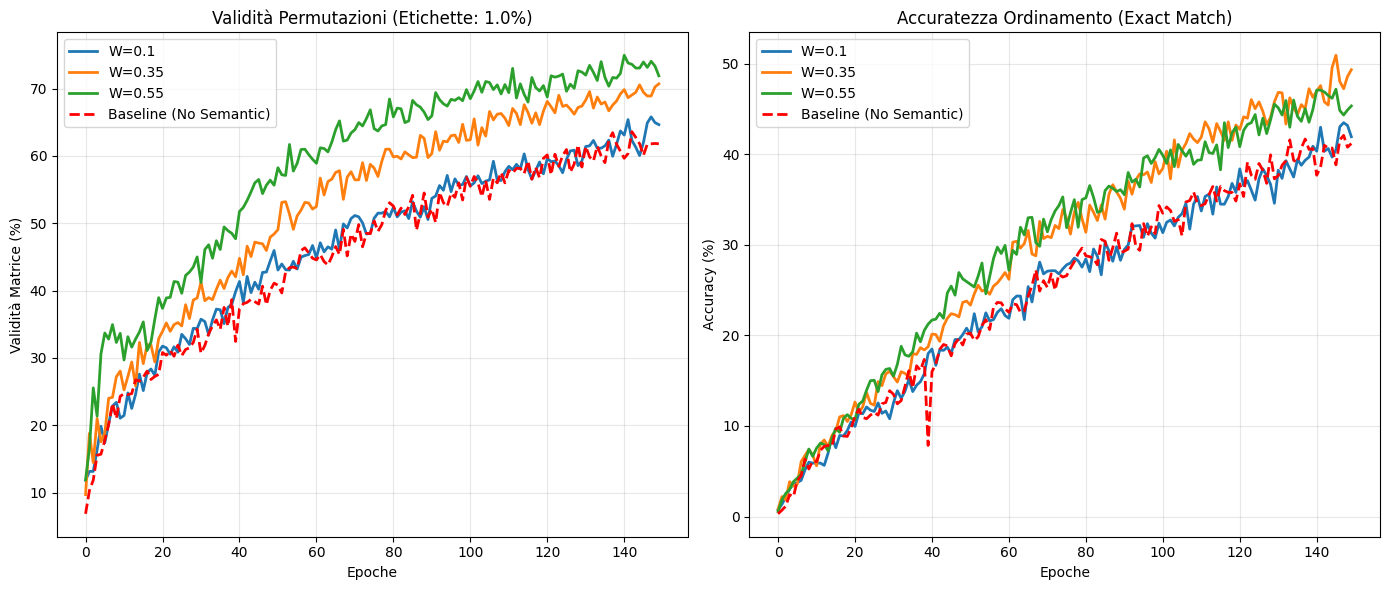


RIEPILOGO RISULTATI FINALI:
W_SEMANTIC = 0.10 -> Validity: 64.65% | Accuracy: 41.95%
W_SEMANTIC = 0.35 -> Validity: 70.70% | Accuracy: 49.35%
W_SEMANTIC = 0.55 -> Validity: 71.90% | Accuracy: 45.35%
Baseline          -> Validity: 61.80% | Accuracy: 41.20%


In [12]:
# --- ESPERIMENTO CON DIVERSI VALORI DI W_SEMANTIC ---

# Valori di W_SEMANTIC da testare
w_values = [0.1, 0.35, 0.55]

# Dizionario per salvare i risultati
results = {}

for w in w_values:
    print(f"\n{'='*60}")
    print(f">>> TRAINING CON W_SEMANTIC = {w}")
    print(f"{'='*60}")
    
    model = SortingNet().to(DEVICE)
    hist = train_semisupervised(model, train_loader, val_loader, 
                                use_semantic_loss=(w > 0), 
                                labeled_ratio=RATIO, 
                                epochs=EPOCHS,
                                w_semantic=w)
    
    results[w] = {
        'model': model,
        'history': hist
    }

# --- TRAINING BASELINE (Senza Semantic Loss per confronto) ---
print(f"\n{'='*60}")
print(">>> TRAINING BASELINE (No Semantic Loss)")
print(f"{'='*60}")
model_base = SortingNet().to(DEVICE)
hist_base = train_semisupervised(model_base, train_loader, val_loader, 
                                 use_semantic_loss=False, 
                                 labeled_ratio=RATIO, 
                                 epochs=EPOCHS)

# --- GRAFICI COMPARATIVI ---
plt.figure(figsize=(14, 6))

# Grafico Validità
plt.subplot(1, 2, 1)
for w in w_values:
    plt.plot(results[w]['history']['validity'], label=f'W={w}', linewidth=2)
plt.plot(hist_base['validity'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Validità Permutazioni (Etichette: {RATIO*100}%)")
plt.xlabel("Epoche")
plt.ylabel("Validità Matrice (%)")
plt.legend()
plt.grid(alpha=0.3)

# Grafico Accuracy
plt.subplot(1, 2, 2)
for w in w_values:
    plt.plot(results[w]['history']['accuracy'], label=f'W={w}', linewidth=2)
plt.plot(hist_base['accuracy'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Accuratezza Ordinamento (Exact Match)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- STAMPA RISULTATI FINALI ---
print("\n" + "="*60)
print("RIEPILOGO RISULTATI FINALI:")
print("="*60)
for w in w_values:
    final_validity = results[w]['history']['validity'][-1]
    final_accuracy = results[w]['history']['accuracy'][-1]
    print(f"W_SEMANTIC = {w:4.2f} -> Validity: {final_validity:5.2f}% | Accuracy: {final_accuracy:5.2f}%")

final_validity_base = hist_base['validity'][-1]
final_accuracy_base = hist_base['accuracy'][-1]
print(f"Baseline          -> Validity: {final_validity_base:5.2f}% | Accuracy: {final_accuracy_base:5.2f}%")

In [11]:
def final_test_metrics(model, test_loader):
    model.eval()
    
    total_samples = 0
    total_elements = 0
    
    # Contatori per le 3 metriche
    correct_sorts = 0      # Coherent
    valid_constraints = 0  # Constraint
    correct_elements = 0   # Incoherent
    
    print("--- Avvio Fase di Testing Finale ---")
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            
            # Forward pass
            outputs = model(images)
            
            # --- Calcoli ---
            # 1. Convertiamo le probabilità in indici (0-4)
            # Preds: per ogni riga (immagine), qual è la colonna (posizione) scelta?
            preds = torch.argmax(outputs, dim=2)      # Shape: (Batch, 5)
            true_labels = torch.argmax(targets, dim=2) # Shape: (Batch, 5)
            
            batch_size = images.size(0)
            total_samples += batch_size
            total_elements += (batch_size * 5) # 5 elementi per ogni esempio
            
            # METRICA A: Coherent Accuracy (Tutto l'ordinamento è giusto?)
            # Confrontiamo le righe intere. .all(dim=1) restituisce True solo se tutti i 5 elementi coincidono
            rows_match = (preds == true_labels).all(dim=1)
            correct_sorts += rows_match.sum().item()
            
            # METRICA B: Incoherent Accuracy (Quanti singoli numeri sono al posto giusto?)
            # Confrontiamo elemento per elemento
            correct_elements += (preds == true_labels).sum().item()
            
            # METRICA C: Constraint Accuracy (È una permutazione valida?)
            # Una matrice è valida se predice 5 posizioni DIVERSE per le 5 immagini.
            # Esempio Valido: [0, 1, 2, 3, 4] (tutti unici)
            # Esempio Invalido: [0, 1, 2, 0, 4] (il '0' è ripetuto, manca il '3')
            for i in range(batch_size):
                pred_row = preds[i] # Vettore di 5 posizioni predette
                unique_values = torch.unique(pred_row)
                if len(unique_values) == 5:
                    valid_constraints += 1

    # --- Risultati Finali ---
    coherent_acc = 100.0 * correct_sorts / total_samples
    incoherent_acc = 100.0 * correct_elements / total_elements
    constraint_acc = 100.0 * valid_constraints / total_samples
    
    print(f"\nRISULTATI DEL TEST SU {total_samples} ESEMPI:")
    print(f"1. Coherent Accuracy (Ordinamento Perfetto):  {coherent_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Coherent')")
    print(f"2. Incoherent Accuracy (Elementi Corretti):   {incoherent_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Incoherent')")
    print(f"3. Constraint Accuracy (Matrici Valide):      {constraint_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Constraint')")
    
    return coherent_acc, incoherent_acc, constraint_acc

# ESECUZIONE TEST SU TUTTI I MODELLI
print("\n" + "="*60)
print("TEST FINALE SU TEST SET")
print("="*60)

test_results = {}

for w in w_values:
    print(f"\n>>> Testing model with W_SEMANTIC = {w}")
    coherent, incoherent, constraint = final_test_metrics(results[w]['model'], test_loader)
    test_results[w] = {
        'coherent': coherent,
        'incoherent': incoherent,
        'constraint': constraint
    }

print(f"\n>>> Testing Baseline model (No Semantic Loss)")
coherent_base, incoherent_base, constraint_base = final_test_metrics(model_base, test_loader)

# --- TABELLA RIEPILOGATIVA ---
print("\n" + "="*60)
print("TABELLA COMPARATIVA RISULTATI TEST:")
print("="*60)
print(f"{'Model':<20} {'Coherent':<12} {'Incoherent':<12} {'Constraint':<12}")
print("-"*60)
for w in w_values:
    print(f"W_SEMANTIC={w:<7.2f}   {test_results[w]['coherent']:>6.2f}%      {test_results[w]['incoherent']:>6.2f}%      {test_results[w]['constraint']:>6.2f}%")
print(f"{'Baseline':<20} {coherent_base:>6.2f}%      {incoherent_base:>6.2f}%      {constraint_base:>6.2f}%")


TEST FINALE SU TEST SET

>>> Testing model with W_SEMANTIC = 0.0
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  41.88%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):   77.74%
   -> (Metriche Paper: 'Incoherent')
3. Constraint Accuracy (Matrici Valide):      61.69%
   -> (Metriche Paper: 'Constraint')

>>> Testing model with W_SEMANTIC = 0.1
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  42.43%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):   77.94%
   -> (Metriche Paper: 'Incoherent')
3. Constraint Accuracy (Matrici Valide):      62.69%
   -> (Metriche Paper: 'Constraint')

>>> Testing model with W_SEMANTIC = 0.35
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  46.79%
   -> (Metriche Paper: 'Coherent')
2. In